In [1]:
import pandas as pd
import json
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import datashader as ds
from datashader.mpl_ext import dsshow

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

/tscc/nfs/home/avicary/miniforge3/envs/jupenv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#generate GeCKOLibrary, which is a dataframe from the GeCKO Library A and B csv files

LibraryA = pd.read_csv('human_geckov2_library_a_09mar2015.csv') #Addgene 1000000048
LibraryB = pd.read_csv('human_geckov2_library_b_09mar2015.csv') #Addgene 1000000049
LibraryA.drop(LibraryA.columns[3], axis=1, inplace=True)
LibraryB.drop(LibraryB.columns[3], axis=1, inplace=True)

GeCKOLibrary = pd.concat([LibraryA, LibraryB], ignore_index=True)
GeCKOLibrary = GeCKOLibrary.sort_values(by=['gene_id','UID'])
GeCKOLibrary.reset_index(inplace=True)
GeCKOLibrary.drop(GeCKOLibrary.columns[0], axis=1, inplace=True)
display(GeCKOLibrary)

,gene_id,UID,seq
0,A1BG,HGLibA_00001,GTCGCTGAGCTCCGATTCGA
1,A1BG,HGLibA_00002,ACCTGTAGTTGCCGGCGTGC
2,A1BG,HGLibA_00003,CGTCAGCGTCACATTGGCCA
3,A1BG,HGLibB_00001,CAATGTGACGCTGACGTGCC
4,A1BG,HGLibB_00002,TGTCTCCGCAGGTGTCACCT
...,...,...,...
123406,hsa-mir-99a,HGLibA_64379,ATCTACGGGTTTATGCCAAT
123407,hsa-mir-99b,HGLibA_64380,CACCCGTAGAACCGACCTTG
123408,hsa-mir-99b,HGLibA_64381,CCCGTAGAACCGACCTTGCG
123409,hsa-mir-99b,HGLibA_64382,CGCACACAAGCTCGTGTCTG


In [3]:
def reverseComplement(sequence):
    RC = ""
    for i in reversed(range(len(sequence))):
        if sequence[i]=="A":
            comp = "T"
        elif sequence[i]=="T":
            comp = "A"
        elif sequence[i]=="C":
            comp = "G"
        elif sequence[i]=="G":
            comp = "C"
        RC = RC+comp
    return RC

In [4]:
# add a column 'RC' to the GeCKOLibrary dataframe with the reverse complement of each gRNA sequence
for index, row in GeCKOLibrary.iterrows():
    GeCKOLibrary.at[index,'RC'] = reverseComplement(GeCKOLibrary.at[index, 'seq'])
    
display(GeCKOLibrary)

,gene_id,UID,seq,RC
0,A1BG,HGLibA_00001,GTCGCTGAGCTCCGATTCGA,TCGAATCGGAGCTCAGCGAC
1,A1BG,HGLibA_00002,ACCTGTAGTTGCCGGCGTGC,GCACGCCGGCAACTACAGGT
2,A1BG,HGLibA_00003,CGTCAGCGTCACATTGGCCA,TGGCCAATGTGACGCTGACG
3,A1BG,HGLibB_00001,CAATGTGACGCTGACGTGCC,GGCACGTCAGCGTCACATTG
4,A1BG,HGLibB_00002,TGTCTCCGCAGGTGTCACCT,AGGTGACACCTGCGGAGACA
...,...,...,...,...
123406,hsa-mir-99a,HGLibA_64379,ATCTACGGGTTTATGCCAAT,ATTGGCATAAACCCGTAGAT
123407,hsa-mir-99b,HGLibA_64380,CACCCGTAGAACCGACCTTG,CAAGGTCGGTTCTACGGGTG
123408,hsa-mir-99b,HGLibA_64381,CCCGTAGAACCGACCTTGCG,CGCAAGGTCGGTTCTACGGG
123409,hsa-mir-99b,HGLibA_64382,CGCACACAAGCTCGTGTCTG,CAGACACGAGCTTGTGTGCG


In [5]:
#make dictionary for all distinct gRNA sequences in the reads and their counts
#dictionary is variable "data"
#repeat for all R2 files (plasmid, gDNA, RNA)

currLine = 0
data = {}
with open('Sequencing/flugDNA-1_R2_001.fastq') as infile:
    for line in infile:
        if line != '':
            if currLine == 1:
                if 'CTAGCTCTAAAAC' in line:
                    position = line.index('CTAGCTCTAAAAC')
                    if line[position+33:position+43] == 'CGGTGTTTCG':
                        sequence = line[position+13:position+33]
                        currDict = data
                        for letter in sequence:
                            if letter not in currDict:
                                currDict[letter] = {}
                            currDict = currDict[letter]
                        if 'count' in currDict:
                            currDict['count'] += 1
                        else:
                            currDict['count'] = 1
            currLine = (currLine+1)%4
            
#write dictionary of reads to output file (txt file)
with open('Sequencing/DNA-1_guides.txt', 'w') as resultsFile:
    resultsFile.write(json.dumps(data))

In [6]:
#read in file to a new dictionary: guidesDict

with open('Sequencing/DNA-1_guides.txt') as resultsFile:
    resultsString = resultsFile.read()
guidesDict = json.loads(resultsString)

In [7]:
#go through GeCKOLibrary dataframe row by row.
#variable "sequence" is a string of the reverse complement of the gRNA in that row
#search guidesDict for the gRNA RC sequence. At the first letter that does not match a read, stop searching and set found Boolean to False (default for each sequence is True)
#if complete gRNA is found, store the count of that gRNA in "count" variable. If not, count = 0.
#add a row to the assignedGuides dataframe for the counts of each gRNA in the GeCKO library.

#write assignedGuides to csv file - can analyze in Excel

assignedGuides = []
for index, row in GeCKOLibrary.iterrows():
    sequence = GeCKOLibrary.at[index,'RC']
    currDict = guidesDict
    found = True
    for letter in sequence:
        if letter not in currDict:
            found = False
            break
        else:
            currDict = currDict[letter]
    if found:
        count = currDict["count"]
    else:
        count = 0
    assignedGuides += [pd.DataFrame({'seq':[GeCKOLibrary.at[index,'seq']], 
                                     'gene_id':[GeCKOLibrary.at[index,'gene_id']], 
                                     'UID':[GeCKOLibrary.at[index,'UID']], 'count':[count]})]

assignedGuides = pd.concat(assignedGuides).reset_index(drop=True)
assignedGuides.to_csv("Sequencing/DNA-1_guideCounts.csv")

In [8]:
#print total reads that were assigned to a gRNA sequence and number of gRNAs with zero reads

zeros = 0
total = 0
for index, row in assignedGuides.iterrows():
    count = assignedGuides.at[index,'count']
    if count == 0:
        zeros +=1
    else:
        total += count
print(total)
print(zeros)

22961476
6499


In [12]:
guideCounts

,gRNA,gene_id,UID,DNA_1,RNA_1,DNA_2,RNA_2,DNA_3,RNA_3
0,GTCGCTGAGCTCCGATTCGA,A1BG,HGLibA_00001,134,363,583,640,148,125
1,ACCTGTAGTTGCCGGCGTGC,A1BG,HGLibA_00002,136,0,338,0,66,0
2,CGTCAGCGTCACATTGGCCA,A1BG,HGLibA_00003,474,237,570,342,485,452
3,CAATGTGACGCTGACGTGCC,A1BG,HGLibB_00001,760,935,1326,1660,940,417
4,TGTCTCCGCAGGTGTCACCT,A1BG,HGLibB_00002,110,237,108,0,86,392
...,...,...,...,...,...,...,...,...,...
123406,ATCTACGGGTTTATGCCAAT,hsa-mir-99a,HGLibA_64379,38,0,68,0,186,393
123407,CACCCGTAGAACCGACCTTG,hsa-mir-99b,HGLibA_64380,67,126,76,0,117,0
123408,CCCGTAGAACCGACCTTGCG,hsa-mir-99b,HGLibA_64381,77,0,63,0,90,422
123409,CGCACACAAGCTCGTGTCTG,hsa-mir-99b,HGLibA_64382,258,396,225,0,164,0


In [9]:
#Once csv files have been made with counts for each gRNA in the gDNA and RNA sequencing files for each replicate,
#now we can compile the information into one table to use as input for MAGeCK analysis.

lib1DNA = pd.read_csv('Sequencing/DNA-1_guideCounts.csv')
lib2DNA = pd.read_csv('Sequencing/DNA-2_guideCounts.csv')
lib3DNA = pd.read_csv('Sequencing/DNA-3_guideCounts.csv')
lib1RNA = pd.read_csv('Sequencing/RNA-1_guideCounts.csv')
lib2RNA = pd.read_csv('Sequencing/RNA-2_guideCounts.csv')
lib3RNA = pd.read_csv('Sequencing/RNA-3_guideCounts.csv')

lib1DNA.drop(lib1DNA.columns[0], axis=1, inplace=True)
lib2DNA.drop(lib2DNA.columns[0], axis=1, inplace=True)
lib3DNA.drop(lib3DNA.columns[0], axis=1, inplace=True)
lib1RNA.drop(lib1RNA.columns[0], axis=1, inplace=True)
lib2RNA.drop(lib2RNA.columns[0], axis=1, inplace=True)
lib3RNA.drop(lib3RNA.columns[0], axis=1, inplace=True)

lib1 = lib1DNA.merge(lib1RNA, how='left', on=['seq','gene_id','UID'], suffixes=('-1_DNA','-1_RNA'))
lib2 = lib2DNA.merge(lib2RNA, how='left', on=['seq','gene_id','UID'], suffixes=('-2_DNA','-2_RNA'))
lib3 = lib3DNA.merge(lib3RNA, how='left', on=['seq','gene_id','UID'], suffixes=('-3_DNA','-3_RNA'))

guideCounts = lib1.merge(lib2, how='left', on=['seq','gene_id','UID'], suffixes=('_1','_2'))
guideCounts = guideCounts.merge(lib3, how='left', on=['seq','gene_id','UID'])
guideCounts = guideCounts.rename(columns={"seq":"gRNA", "count-1_DNA":"DNA_1", 
                                          "count-2_DNA":"DNA_2", "count-3_DNA":"DNA_3", 
                                          "count-1_RNA":"RNA_1", "count-2_RNA":"RNA_2", 
                                          "count-3_RNA":"RNA_3"})
guideCounts.to_csv("Sequencing/guideCounts.csv")

In [13]:
guideCounts_threshold25 = guideCounts[(guideCounts['DNA_1']>24) & (guideCounts['DNA_2']>24) & (guideCounts['DNA_3']>24)]
guideCounts_threshold25.to_csv("Sequencing/guideCounts_threshold25.csv")

In [20]:
mageckCounts_threshold25 = guideCounts_threshold25[['UID','gene_id','DNA_1','RNA_1','DNA_2','RNA_2','DNA_3','RNA_3']]
mageckCounts_threshold25 = mageckCounts_threshold25.rename(columns={"UID":"sgRNA", "gene_id":"gene", "DNA_1":"Flu1_DNA", "RNA_1":"Flu1_RNA", "DNA_2":"Flu2_DNA", "RNA_2":"Flu2_RNA", "DNA_3":"Flu3_DNA", "RNA_3":"Flu3_RNA"})
mageckCounts_threshold25.to_csv('mageckCounts_threshold25.txt', sep = '\t', index=False)

In [21]:
#make a list of the non-targeting guides.
#We will tell MAGeCK to use these guides for normalization and as the null distribution for statistical analysis.

nontarget = mageckCounts_threshold25[mageckCounts_threshold25.gene.str.slice(stop=12) == 'NonTargeting']
nontarget.sgRNA.to_csv('nontarget.txt', sep = '\t', header=False, index=False)

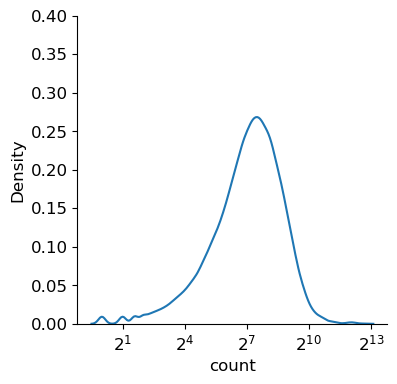

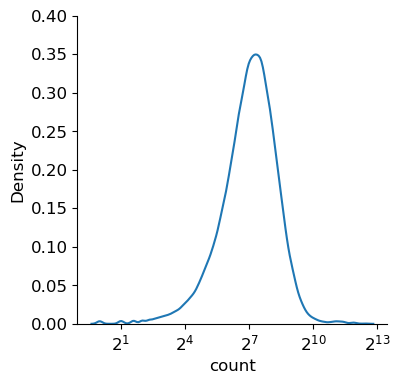

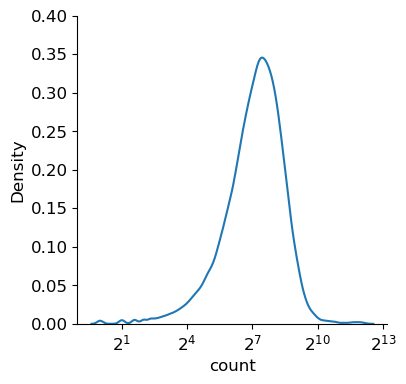

In [22]:
#Data visualization: Representation of GeCKO library gRNAs in CRITR-seq libraries
#can do this for plasmid, gDNA, and RNA libraries from each replicate
lib1 = pd.read_csv('Sequencing/plasmid-1_guideCounts.csv')
lib2 = pd.read_csv('Sequencing/plasmid-2_guideCounts.csv')
lib3 = pd.read_csv('Sequencing/plasmid-3_guideCounts.csv')

lib1.drop(lib1.columns[0], axis=1, inplace=True)
lib2.drop(lib2.columns[0], axis=1, inplace=True)
lib3.drop(lib3.columns[0], axis=1, inplace=True)

lib1_pos = lib1[lib1['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib1_pos, x='count', log_scale=2)
plt.ylim(0,0.4) #adjust y-limit to fit all replicates
sns.despine()
plt.savefig('Figures/plasmid-1_dist.pdf', format='pdf', bbox_inches = "tight")

lib2_pos = lib2[lib2['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib2_pos, x='count', log_scale=2)
plt.ylim(0,0.4)
sns.despine()
plt.savefig('Figures/plasmid-2_dist.pdf', format='pdf', bbox_inches = "tight")

lib3_pos = lib3[lib3['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib3_pos, x='count', log_scale=2)
plt.ylim(0,0.4)
sns.despine()
plt.savefig('Figures/plasmid-3_dist.pdf', format='pdf', bbox_inches = "tight")

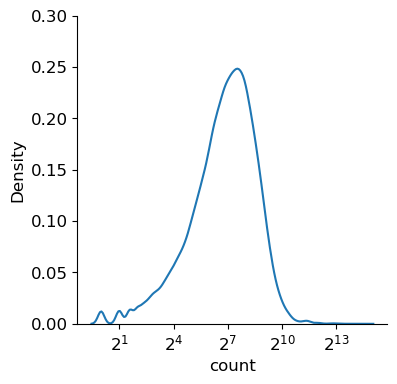

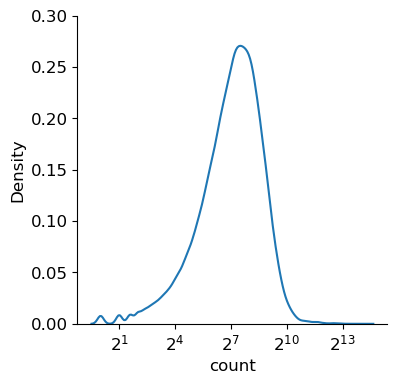

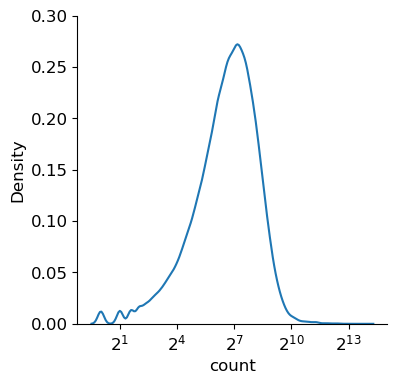

In [23]:
lib1 = pd.read_csv('Sequencing/DNA-1_guideCounts.csv')
lib2 = pd.read_csv('Sequencing/DNA-2_guideCounts.csv')
lib3 = pd.read_csv('Sequencing/DNA-3_guideCounts.csv')

lib1.drop(lib1.columns[0], axis=1, inplace=True)
lib2.drop(lib2.columns[0], axis=1, inplace=True)
lib3.drop(lib3.columns[0], axis=1, inplace=True)

lib1_pos = lib1[lib1['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib1_pos, x='count', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-1_dist.pdf', format='pdf', bbox_inches = "tight")

lib2_pos = lib2[lib2['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib2_pos, x='count', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-2_dist.pdf', format='pdf', bbox_inches = "tight")

lib3_pos = lib3[lib3['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib3_pos, x='count', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-3_dist.pdf', format='pdf', bbox_inches = "tight")

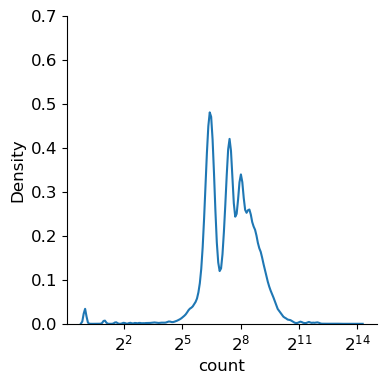

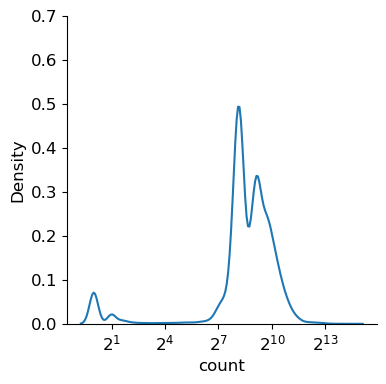

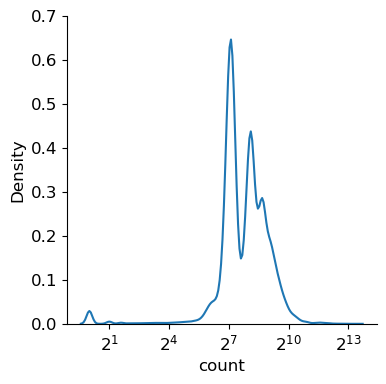

In [24]:
lib1 = pd.read_csv('Sequencing/RNA-1_guideCounts.csv')
lib2 = pd.read_csv('Sequencing/RNA-2_guideCounts.csv')
lib3 = pd.read_csv('Sequencing/RNA-3_guideCounts.csv')

lib1.drop(lib1.columns[0], axis=1, inplace=True)
lib2.drop(lib2.columns[0], axis=1, inplace=True)
lib3.drop(lib3.columns[0], axis=1, inplace=True)

lib1_pos = lib1[lib1['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib1_pos, x='count', log_scale=2, bw_adjust=0.5)
plt.ylim(0,0.7)
sns.despine()
plt.savefig('Figures/RNA-1_dist.pdf', format='pdf', bbox_inches = "tight")

lib2_pos = lib2[lib2['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib2_pos, x='count', log_scale=2)
plt.ylim(0,0.7)
sns.despine()
plt.savefig('Figures/RNA-2_dist.pdf', format='pdf', bbox_inches = "tight")

lib3_pos = lib3[lib3['count'] > 0]
fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=lib3_pos, x='count', log_scale=2)
plt.ylim(0,0.7)
sns.despine()
plt.savefig('Figures/RNA-3_dist.pdf', format='pdf', bbox_inches = "tight")

In [25]:
#Data visualization, part 2: Plot correlation between replicates
#First look at all gRNAs included in MAGeCK analysis
#For each gRNA, compare the mRNA/gDNA ratio between replicates

allguides = pd.read_csv('threshold.sgrna_summary.csv')

rep = []
guides = []
for index, row in allguides.iterrows():
    sgrna = allguides.at[index,'sgrna']
    replicate = sgrna.split('_')[2][1]
    guide = sgrna.split('_')[0] + sgrna.split('_')[1]
    rep += [replicate]
    guides += [guide]
allguides['replicate'] = rep
allguides['sgrna'] = guides

In [26]:
guides_rep1 = allguides[allguides.replicate == '0'].sort_values('sgrna')
guides_rep2 = allguides[allguides.replicate == '1'].sort_values('sgrna')
guides_rep3 = allguides[allguides.replicate == '2'].sort_values('sgrna')

guides_rep1 = guides_rep1[['Gene','LFC']].groupby('Gene').median().reset_index()
guides_rep2 = guides_rep2[['Gene','LFC']].groupby('Gene').median().reset_index()
guides_rep3 = guides_rep3[['Gene','LFC']].groupby('Gene').median().reset_index()

combined = guides_rep1.merge(guides_rep2, how='inner', on='Gene', suffixes=('-1','-2'))
combined = combined.merge(guides_rep3, how='inner', on='Gene').rename(columns={"LFC": "LFC-3"})

#print min and max values for setting the axis limits on the graphs
print(combined['LFC-1'].min())
print(combined['LFC-2'].min())
print(combined['LFC-3'].min())

print(combined['LFC-1'].max())
print(combined['LFC-2'].max())
print(combined['LFC-3'].max())

-9.1904
-9.096
-9.5969
3.3302
4.1737
3.9311


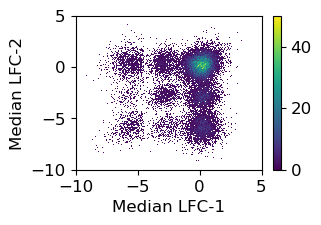

In [27]:
def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=50,
        norm="linear",
        aspect="auto",
        ax=ax, rasterized=True
    )

    plt.colorbar(dsartist)

x = combined['LFC-1']
y = combined['LFC-2']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-10,5)
plt.ylim(-10,5)
plt.xticks(np.arange(-10, 6, 5)) 
plt.yticks(np.arange(-10, 6, 5))
plt.xlabel('Median LFC-1')
plt.ylabel('Median LFC-2')
plt.savefig('Figures/corr_genes_all_rep1-2.pdf', format='pdf', bbox_inches = "tight")

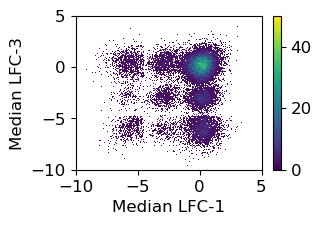

In [28]:
x = combined['LFC-1']
y = combined['LFC-3']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-10,5)
plt.ylim(-10,5)
plt.xticks(np.arange(-10, 6, 5)) 
plt.yticks(np.arange(-10, 6, 5))
plt.xlabel('Median LFC-1')
plt.ylabel('Median LFC-3')
plt.savefig('Figures/corr_genes_all_rep1-3.pdf', format='pdf', bbox_inches = "tight")

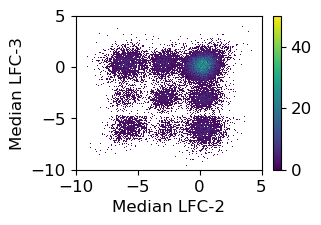

In [29]:
x = combined['LFC-2']
y = combined['LFC-3']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-10,5)
plt.ylim(-10,5)
plt.xticks(np.arange(-10, 6, 5)) 
plt.yticks(np.arange(-10, 6, 5))
plt.xlabel('Median LFC-2')
plt.ylabel('Median LFC-3')
plt.savefig('Figures/corr_genes_all_rep2-3.pdf', format='pdf', bbox_inches = "tight")

In [30]:
#To minimize noise due to stochastic dropout in the RNA sequencing,
#now look only at guides with over 45 reads in the mRNA.
#Take the median mRNA/gDNA ratio of the remaining guides and compare between replicates.

guides_rep1 = allguides[allguides.replicate == '0'].sort_values('sgrna')
guides_rep2 = allguides[allguides.replicate == '1'].sort_values('sgrna')
guides_rep3 = allguides[allguides.replicate == '2'].sort_values('sgrna')

guides_rep1 = guides_rep1[guides_rep1['treatment_count'] > 45]
guides_rep2 = guides_rep2[guides_rep2['treatment_count'] > 45]
guides_rep3 = guides_rep3[guides_rep3['treatment_count'] > 45]

guides_rep1 = guides_rep1[['Gene','LFC']].groupby('Gene').median().reset_index()
guides_rep2 = guides_rep2[['Gene','LFC']].groupby('Gene').median().reset_index()
guides_rep3 = guides_rep3[['Gene','LFC']].groupby('Gene').median().reset_index()

combined = guides_rep1.merge(guides_rep2, how='inner', on='Gene', suffixes=('-1','-2'))
combined = combined.merge(guides_rep3, how='inner', on='Gene').rename(columns={"LFC": "LFC-3"})

print(combined['LFC-1'].min())
print(combined['LFC-2'].min())
print(combined['LFC-3'].min())

print(combined['LFC-1'].max())
print(combined['LFC-2'].max())
print(combined['LFC-3'].max())

-2.7879
-2.9511
-2.8008
4.2925
4.5395
4.3915


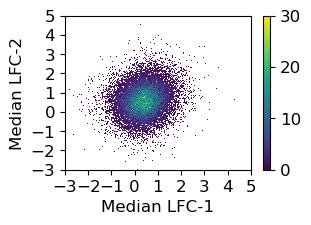

In [31]:
def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=30,
        norm="linear",
        aspect="auto",
        ax=ax, rasterized=True
    )

    plt.colorbar(dsartist)

x = combined['LFC-1']
y = combined['LFC-2']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-3,5)
plt.ylim(-3,5)
plt.xticks(np.arange(-3, 6, 1)) 
plt.yticks(np.arange(-3, 6, 1))
plt.xlabel('Median LFC-1')
plt.ylabel('Median LFC-2')
plt.savefig('Figures/genes_threshold_rep1-2.pdf', format='pdf', bbox_inches = "tight")

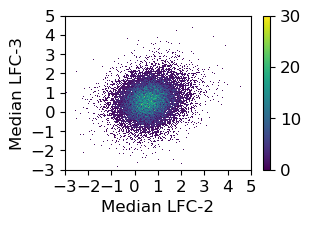

In [32]:
x = combined['LFC-2']
y = combined['LFC-3']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-3,5)
plt.ylim(-3,5)
plt.xticks(np.arange(-3, 6, 1)) 
plt.yticks(np.arange(-3, 6, 1))
plt.xlabel('Median LFC-2')
plt.ylabel('Median LFC-3')
plt.savefig('Figures/genes_threshold_rep2-3.pdf', format='pdf', bbox_inches = "tight")

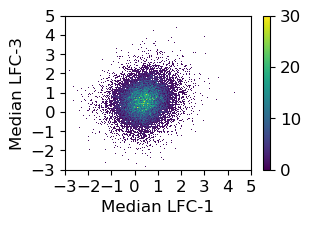

In [33]:
x = combined['LFC-1']
y = combined['LFC-3']


fig, ax = plt.subplots(figsize=(3,2), rasterized=False)
using_datashader(ax, x, y)
plt.xlim(-3,5)
plt.ylim(-3,5)
plt.xticks(np.arange(-3, 6, 1)) 
plt.yticks(np.arange(-3, 6, 1))
plt.xlabel('Median LFC-1')
plt.ylabel('Median LFC-3')
plt.savefig('Figures/genes_threshold_rep1-3.pdf', format='pdf', bbox_inches = "tight")